In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mpl.rcParams['figure.figsize'] = (10,2)
mpl.rcParams['axes.grid'] = False

#test

In [17]:
dfrefrange = pd.read_csv("ngboost_dataset.gz", index_col=0, parse_dates=True)

In [4]:
pathCSV = r'ProcessedDataCenterHall.csv'
df = pd.read_csv(pathCSV, index_col=0, parse_dates=True)

In [21]:
#truncate the data same as in ngboost dataset
df = df.loc[dfrefrange.index,:]

In [23]:
df=df.resample('15Min').mean()

In [24]:
df.head()

,RealPower,ReactivePower
DateTime,,
2019-10-13 00:00:00,60.660,31.931
2019-10-13 00:15:00,58.245,31.810
2019-10-13 00:30:00,57.985,32.102
2019-10-13 00:45:00,58.337,32.509
2019-10-13 01:00:00,58.118,33.032


In [25]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [26]:
adf_test(df['RealPower'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.333843e+01
p-value                 5.987162e-25
# lags used             4.000000e+01
# observations          1.330400e+04
critical value (1%)    -3.430842e+00
critical value (5%)    -2.861757e+00
critical value (10%)   -2.566886e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [27]:
adf_test(df['ReactivePower'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.393725e+01
p-value                 4.965314e-26
# lags used             4.100000e+01
# observations          1.330300e+04
critical value (1%)    -3.430842e+00
critical value (5%)    -2.861757e+00
critical value (10%)   -2.566886e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [28]:
# Uncomment if you want to train and test whole dataset
test_obs = int(0.8*(len(df)))
train = df[:test_obs]
test = df[test_obs:]

# Uncomment if you want to train and test last 100 data
# test_obs = 4
# train = df[-50000:-test_obs]
# test = df[-test_obs:]

In [29]:
train.shape

(10676, 2)

In [30]:
for i in range(100):
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 0
AIC:  10.285459372707448
BIC:  10.286822383855917

Order = 1
AIC:  4.029513702934683
BIC:  4.033603066778109

Order = 2
AIC:  3.955783089156301
BIC:  3.9625992463203388

Order = 3
AIC:  3.935838760167106
BIC:  3.9453821513913914

Order = 4
AIC:  3.923840599636525
BIC:  3.936111665774718

Order = 5
AIC:  3.8952831455376256
BIC:  3.9102823275574514

Order = 6
AIC:  3.875997531400204
BIC:  3.893725270383493

Order = 7
AIC:  3.8680551154585294
BIC:  3.888511852601255

Order = 8
AIC:  3.861713197243968
BIC:  3.8848993738562916

Order = 9
AIC:  3.8296866786766586
BIC:  3.8556027361829646

Order = 10
AIC:  3.81818780227253
BIC:  3.8468341822114707

Order = 11
AIC:  3.8166630641209647
BIC:  3.8480402081454983

Order = 12
AIC:  3.8144172364697866
BIC:  3.848525586347218

Order = 13
AIC:  3.7844529911822034
BIC:  3.8212929887942244

Order = 14
AIC:  3.783268816491597
BIC:  3.822840903834328

Order = 15
AIC:  3.7811789131389277
BIC:  3.8234835323229563

Order = 16
AIC:  3.77947145395823

In [31]:
model.select_order(100).summary()

,AIC,BIC,FPE,HQIC
0,10.29,10.29,2.948e+04,10.29
1,4.045,4.049,57.10,4.046
2,3.971,3.978,53.03,3.973
3,3.951,3.960,51.97,3.954
4,3.939,3.951,51.34,3.943
5,3.910,3.925,49.89,3.915
6,3.890,3.908,48.93,3.896
7,3.882,3.903,48.53,3.889
8,3.876,3.899,48.21,3.884
9,3.843,3.869,46.67,3.852


In [32]:
result = model.fit(100)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jan, 2022
Time:                     23:39:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.40429
Nobs:                     10576.0    HQIC:                   3.22133
Log likelihood:          -46152.8    FPE:                    22.8307
AIC:                      3.12809    Det(Omega_mle):         21.9870
--------------------------------------------------------------------
Results for equation RealPower
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      1.587063         0.296122            5.359           0.000
L1.RealPower               0.978883         0.018809           52.042           0.000
L1.ReactivePower           0.133478 

In [34]:
lagged_Values = train.values[-4:]

In [35]:
lagged_Values

array([[73.972, 44.356],
       [77.965, 46.018],
       [78.507, 45.993],
       [78.499, 45.929]])

In [42]:
test_original = df[-test_obs:]
test_original.index = pd.to_datetime(test_original.index)
pred = result.forecast(y=lagged_Values, steps=test_obs) 
print("pred: ", pred)
# idx = pd.date_range('2016-06-06 21:00:00', periods=test_obs, freq='1H') # Uncomment if testing all test data
# idx = pd.date_range('2020-02-29 12:00:00', periods=test_obs, freq='15Min') # Uncomment if testing last 12 data
df_forecast=pd.DataFrame(data=pred, index=test_original.index, columns=['realPower_2d', 'reactivePower_2d'])
print("df_forecast una: ", df_forecast)

pred:  [[119.91694631  61.0263849 ]
 [ 98.61874217  52.48847031]
 [ 95.39147877  51.01901812]
 [ 95.24028116  50.7518633 ]]
df_forecast una:                       realPower_2d  reactivePower_2d
DateTime                                           
2020-02-29 23:00:00    119.916946         61.026385
2020-02-29 23:15:00     98.618742         52.488470
2020-02-29 23:30:00     95.391479         51.019018
2020-02-29 23:45:00     95.240281         50.751863


In [43]:
# test_original = df[-test_obs:]
# test_original.index = pd.to_datetime(test_original.index)
# print("test original: ", test_original)
# print("predicted original: ", df_forecast)

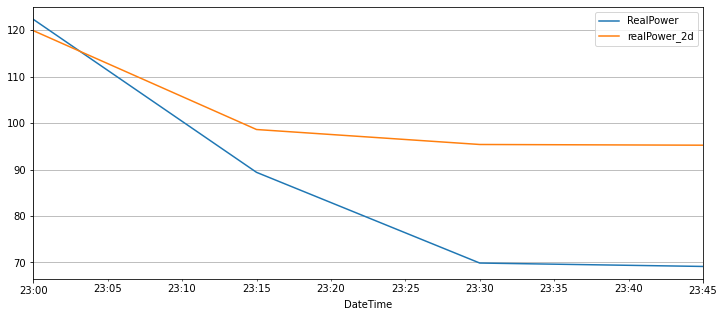

In [44]:
test_original['RealPower'].plot(figsize=(12,5),legend=True, grid=True)
df_forecast['realPower_2d'].plot(legend=True, grid=True)

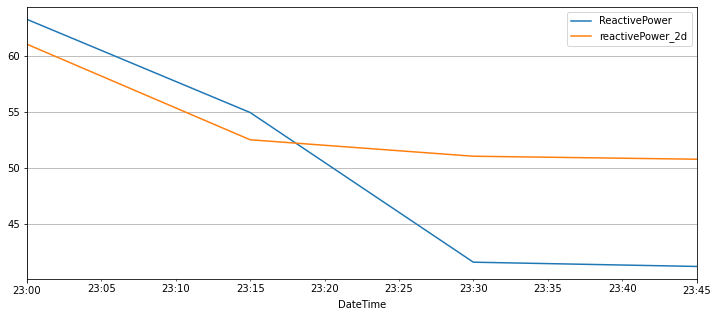

In [45]:
test_original['ReactivePower'].plot(figsize=(12,5),legend=True, grid=True)
df_forecast['reactivePower_2d'].plot(legend=True, grid=True)

In [46]:
# df_forecast['RealPower1d'] = (df['RealPower'].iloc[-test_obs-1]-df['RealPower'].iloc[-test_obs-2]) + df_forecast['realPower_2d'].cumsum()
# print("df_forecast unang una: ", df_forecast)
# df_forecast['RealPowerForecast'] = df['RealPower'].iloc[-test_obs-1] + df_forecast['RealPower1d'].cumsum()
# print("df_forecast pangalawa: ", df_forecast)

In [47]:
# df_forecast['ReactivePower1d'] = (df['ReactivePower'].iloc[-test_obs-1]-df['ReactivePower'].iloc[-test_obs-2]) + df_forecast['reactivePower_2d'].cumsum()
# df_forecast['ReactivePowerForecast'] = df['ReactivePower'].iloc[-test_obs-1] + df_forecast['ReactivePower1d'].cumsum()

In [48]:
# test_original = df[-test_obs:]
# test_original.index = pd.to_datetime(test_original.index)
# print("test original: ", test_original)
# print("predicted original: ", df_forecast)

In [49]:
# test_original['RealPower'].plot(figsize=(12,5),legend=True)
# df_forecast['RealPowerForecast'].plot(legend=True)